# Train a model on CATLAS binary accessibility data

## Set up wandb

In [1]:
import wandb

import anndata
import os
import pandas as pd
import numpy as np
%matplotlib inline

from grelu.data.dataset import AnnDataSeqDataset
from grelu.lightning import LightningModel
from grelu.visualize import plot_distribution, plot_calibration_curve

os.environ["CUDA_VISIBLE_DEVICES"]="1"
wandb.login(host="https://api.wandb.ai")
project_name="human-atac-catlas"

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: avantikalal (grelu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
run = wandb.init(
    entity='grelu', project=project_name, job_type='training', name='train',
    settings=wandb.Settings(
        program_relpath='2_train.ipynb',
        program_abspath='/code/github/gReLU-applications/catlas/2_train.ipynb')
)

## Load preprocessed data

In [3]:
artifact = run.use_artifact('dataset:latest')
dir = artifact.download()
ad = anndata.read_h5ad(os.path.join(dir, "data.h5ad"))

wandb: Downloading large artifact dataset:latest, 179.17MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.3
/opt/conda/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.


## Make datasets

In [4]:
train_dataset = AnnDataSeqDataset(
    ad[:, ad.var.split=='train'].copy(),
    genome='hg38',
    rc=True, # reverse complement
    max_seq_shift=2, # Shift the sequence
    augment_mode="random", # Randomly select which augmentations to apply
)

val_dataset = AnnDataSeqDataset(
    ad[:, ad.var.split=='valid'].copy(), genome='hg38',
)

## Build the model

In [5]:
model_params = {
    'model_type':'EnformerPretrainedModel', # Type of model
    'n_tasks': ad.shape[0], # Number of cell types to predict
    'crop_len':0, # No cropping of the model output
    'n_transformers': 1, # Number of transformer layers; the published Enformer model has 11
}

train_params = {
    'task':'binary', # binary classification
    'lr':1e-4, # learning rate
    'logger': 'wandb', # Logs will be written to wandb
    'batch_size': 3072,
    'num_workers': 32,
    'devices': 0, # GPU index
    'save_dir': project_name,
    'optimizer': 'adam',
    'max_epochs': 10,
    'checkpoint': True, # Save checkpoints
}

model = LightningModel(model_params=model_params, train_params=train_params)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
/opt/conda/lib/python3.11/site-packages/grelu/model/models.py:771: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use cas

## Train the model

In [6]:
trainer = model.train_on_dataset(train_dataset=train_dataset, val_dataset=val_dataset)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/loggers/wandb.py:397: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Validation DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:08<00:00,  2.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       val_accuracy        │    0.4883847236633301     │
│         val_auroc         │    0.5049463510513306     │
│        val_avgprec        │    0.11118414252996445    │
│        val_best_f1        │    0.17346523702144623    │
│         val_loss          │    0.6949121952056885     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name         | Type                    | Params | Mode 
-----------------------------------------------------------------
0 | model        | EnformerPretrainedModel | 72.1 M | train
1 | loss         | BCEWithLogitsLoss       | 0      | train
2 | val_metrics  | MetricCollection        | 0      | train
3 | test_metrics | MetricCollection        | 0      | train
4 | transform    | Identity                | 0      | train
-----------------------------------------------------------------
72.1 M    Trainable params
0         Non-trainable params
72.1 M    Total params
288.279   Total estimated model params size (MB)
240       Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [03:07<00:00,  1.70it/s, v_num=t24e, train_loss_step=0.137]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [03:08<00:00,  1.69it/s, v_num=t24e, train_loss_step=0.134, train_loss_epoch=0.197]
Validation: |                                                                                                                                                                                                        | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████████████████

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 319/319 [03:28<00:00,  1.53it/s, v_num=t24e, train_loss_step=0.118, train_loss_epoch=0.143]


## Load best checkpoint

In [8]:
best_checkpoint = trainer.checkpoint_callback.best_model_path
model = LightningModel.load_from_checkpoint(best_checkpoint)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.7
/opt/conda/lib/python3.11/site-packages/grelu/model/models.py:771: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use cas

## Evaluate

In [10]:
test_dataset = AnnDataSeqDataset(
    ad[:, ad.var.split=='test'].copy(), genome='hg38',
)

In [11]:
%%time
test_metrics = model.test_on_dataset(
    test_dataset,
    batch_size=256,
    devices=0,
    num_workers=8,
    write_path = 'model.ckpt' # Update the checkpoint with the results
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]


Testing DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 284/284 [00:09<00:00, 28.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9416285753250122     │
│        test_auroc         │    0.9053414463996887     │
│       test_avgprec        │    0.6097266674041748     │
│       test_best_f1        │    0.5716205835342407     │
│         test_loss         │    0.16409701108932495    │
└───────────────────────────┴───────────────────────────┘

CPU times: user 13.7 s, sys: 1.66 s, total: 15.4 s
Wall time: 15.7 s


/opt/conda/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 19'. Pick better value with 'binwidth'.


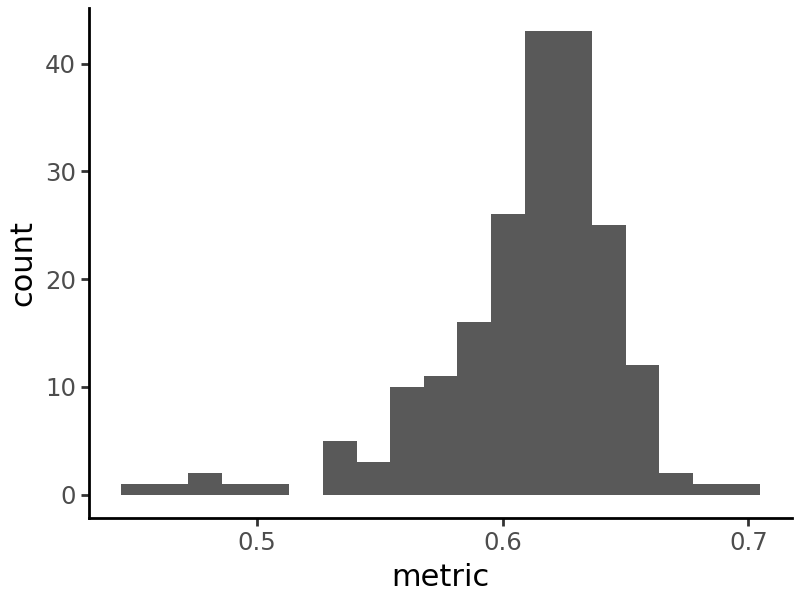

In [12]:
plot_distribution(test_metrics.test_avgprec, method='histogram')

In [13]:
probs = model.predict_on_dataset(test_dataset, devices=0, batch_size=1024)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]
/opt/conda/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: PossibleUserWarning: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 71/71 [00:04<00:00, 14.21it/s]


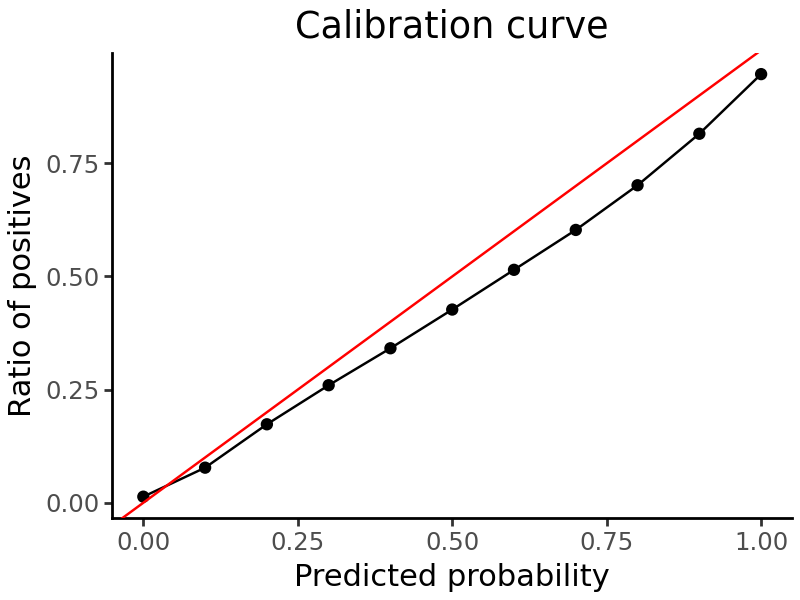

In [14]:
plot_calibration_curve(
    probs,
    test_dataset.labels,
    figsize=(4,3),
    aggregate=True
)

## Save

In [16]:
artifact = wandb.Artifact('model', type='model')
artifact.add_file('model.ckpt', name="model.ckpt")
run.log_artifact(artifact)

<Artifact model>

In [17]:
run.finish()

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇█████
train_loss_epoch,█▂▂▂▂▁▁▁▁▁
train_loss_step,█▇▆▅▄▄▃▃▂▃▃▃▃▃▂▃▂▁▃▂▂▃▂▂▂▃▂▂▂▂▃▂▂▂▁▂▁▃▁▂
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
val_accuracy,▁██████████
val_auroc,▁██████████
val_avgprec,▁▇█████████
val_best_f1,▁▇█████████
val_loss,█▁▁▁▁▁▁▁▁▁▁
epoch,9
train_loss_epoch,0.14265
